## Importing the Necessary Libraries and Reading the Data

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import spacy

import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\omsan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\omsan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omsan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [79]:
og_data = pd.read_csv('questions.csv')

# 1. EDA & Feature Extraction

In [80]:
og_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Checking the split of the data for the two classes

0    6301
1    3699
Name: is_duplicate, dtype: int64


<Axes: >

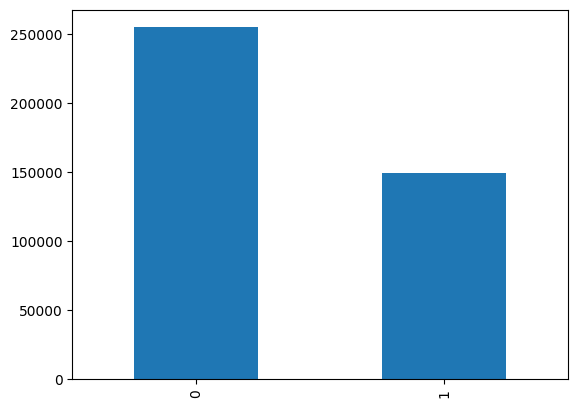

In [81]:
print(data.is_duplicate.value_counts())
og_data['is_duplicate'].value_counts().plot(kind='bar')

In [82]:
# Calculate the percentage of duplicate questions
percentage = og_data.is_duplicate.mean() * 100
print('Percentage of duplicate questions:', round(percentage,2),'%')

Percentage of duplicate questions: 36.92 %


### Now just for the sake of comutational efficiency, we will take a subset of 20,000 question pairs but we would ensure that the split is the same as the original dataset

In [83]:
data = og_data.sample(n=10000, random_state=1)
data = data.reset_index(drop=True)


### Checking for Null Values

In [84]:
## Checkin for missing values
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

Since there are no missing values, we can proceed with the next step

In [85]:
### Checking for duplicate questions
duplicate_pairs = data[data.duplicated(['qid1','qid2'])]
print('Number of duplicate questions:', duplicate_pairs.shape)

Number of duplicate questions: (0, 6)


Since there are no duplicate values, we can proceed with the next step

### Plotting the length of questions

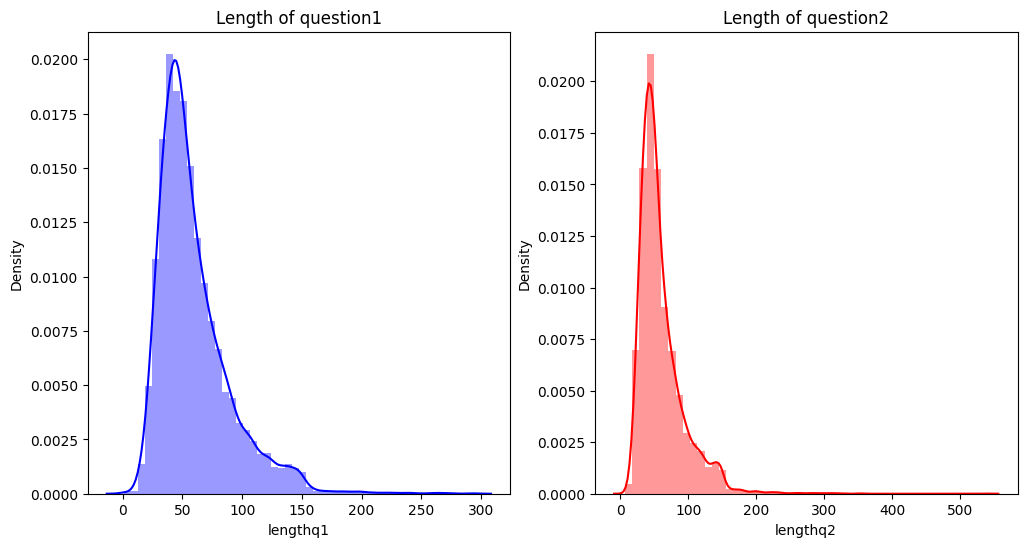

In [86]:
#length of questions
data['lengthq1'] = data['question1'].apply(lambda x: len(str(x)))
data['lengthq2'] = data['question2'].apply(lambda x: len(str(x)))

#plot length of questions
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.distplot(data['lengthq1'], color='blue')
plt.title('Length of question1')
plt.subplot(1,2,2)
sns.distplot(data['lengthq2'], color='red')
plt.title('Length of question2')
plt.show()

### Finding the number of unique words and the most frequent words

Number of unique words:  26307
[('the', 9107), ('What', 7090), ('is', 5491), ('a', 5282), ('I', 5203), ('to', 5113), ('How', 4925), ('in', 4714), ('of', 3763), ('do', 3447)]


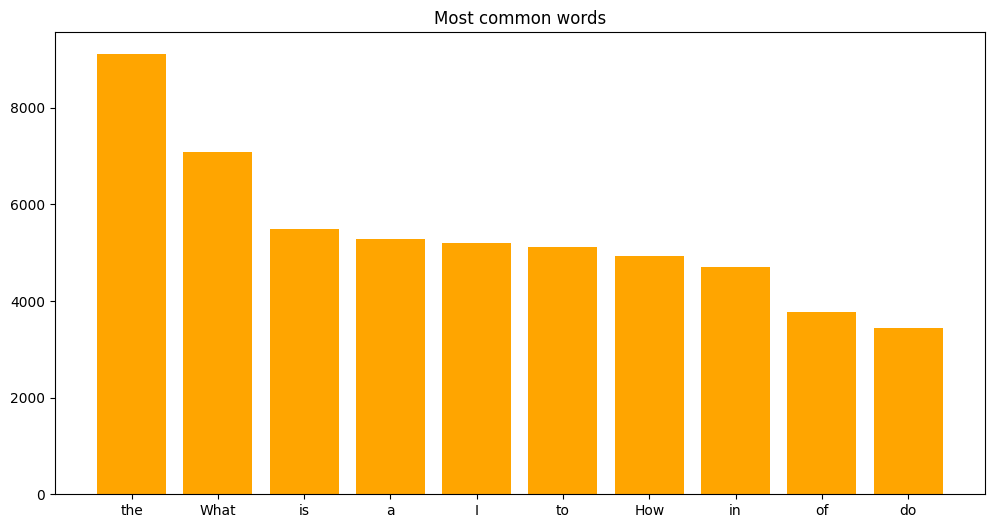

In [87]:
#Getting a full list of questions
questions = list(data['question1']) + list(data['question2'])
len(questions)

#find number of unique words
unique_words = len(set(" ".join(questions).split()))
print("Number of unique words: ", unique_words)

#printing the most common words 
from collections import Counter
cnt = Counter()
for word in questions:
    cnt.update(word.split())
print(cnt.most_common(10))

#plot
most_common = cnt.most_common(10)
most_common = dict(most_common)
plt.figure(figsize=(12, 6))
plt.bar(most_common.keys(), most_common.values(), color='orange')
plt.title('Most common words')
plt.show()

Most of the words are stop words, so we will need to remove them while cleaning the data

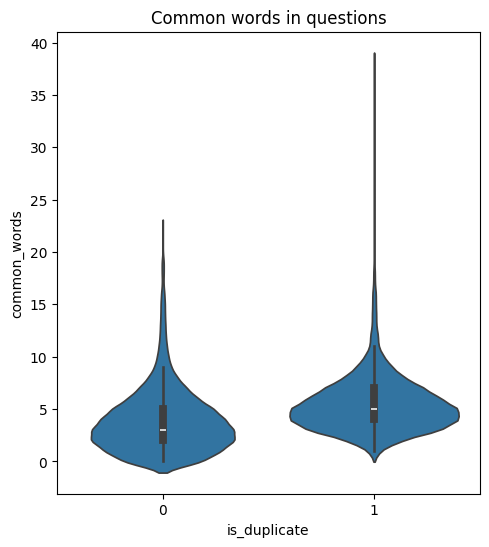

In [88]:
def common_words(row):
    q1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
    q2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
    return len(q1 & q2)

data['common_words'] = data.apply(common_words, axis=1)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_words', data = data)
plt.title('Common words in questions')
plt.show()

 We observe that the number of common words is higher for duplicate questions. This is a good feature to use in our model.

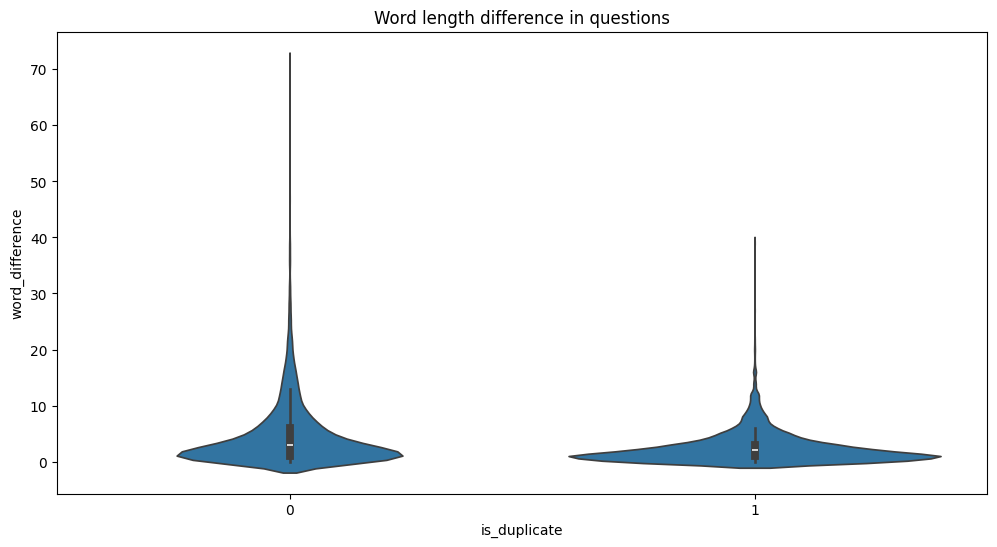

In [89]:
# calculate word length of questions in two columns
data['q1_wordlen'] = data['question1'].apply(lambda x: len(str(x).split()))
data['q2_wordlen'] = data['question2'].apply(lambda x: len(str(x).split()))

# create a new column that has difference in word length
data['word_difference'] = abs(data['q1_wordlen'] - data['q2_wordlen'])

# plot to check the difference in word_difference across duplicate questions and non duplicate
plt.figure(figsize=(12, 6))
sns.violinplot(x = 'is_duplicate', y = 'word_difference', data = data)
plt.title('Word length difference in questions')
plt.show()


No visible pattern observedin word length difference in duplicate and non duplicate questions

# 2. Data Cleaning

## Basic Cleaning

### Removing the Stopwords and dealing with the punctuations and the math symbols

In [90]:
# Download stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to expand contractions
def expand_contractions(text):
    # Dictionary of English contractions
    contractions_dict = {"don't": "do not", "doesn't": "does not", "didn't": "did not",
                         }
    # Regular expression for finding contractions
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    def replace(match):
        return contractions_dict[match.group(0)]

    return contractions_re.sub(replace, text)

#function to handle LaTeX expressions
def clean_math_text(text):

    replacements = {
        # Basic operations and structures
        r'\\frac\{(.*?)\}\{(.*?)\}': r'\1 over \2',
        r'\\sqrt\{(.*?)\}': r'square root of \1',
        r'\\sum_(\{.*?\})\^(\{.*?\})': r'sum from \1 to \2',
        r'\\int_(\{.*?\})\^(\{.*?\})': r'integral from \1 to \2',
        r'\\log_(\{.*?\})\{(.*?)\}': r'log base \1 of \2',
        r'\\lim_(\{.*?\})': r'limit as \1',
        r'(\d+)\^(\{?\d+\}?)': r'\1 to the power of \2',
        r'\\infty': 'infinity',
        r'\\pm': 'plus or minus',
        # Greek letters
        r'\\alpha': 'alpha', r'\\beta': 'beta', r'\\gamma': 'gamma',
        r'\\delta': 'delta', r'\\epsilon': 'epsilon', r'\\zeta': 'zeta',
        r'\\eta': 'eta', r'\\theta': 'theta', r'\\iota': 'iota',
        r'\\kappa': 'kappa', r'\\lambda': 'lambda', r'\\mu': 'mu',
        r'\\nu': 'nu', r'\\xi': 'xi', r'\\omicron': 'omicron',
        r'\\pi': 'pi', r'\\rho': 'rho', r'\\sigma': 'sigma',
        r'\\tau': 'tau', r'\\upsilon': 'upsilon', r'\\phi': 'phi',
        r'\\chi': 'chi', r'\\psi': 'psi', r'\\omega': 'omega',
        # Trigonometric functions
        r'\\sin': 'sine', r'\\cos': 'cosine', r'\\tan': 'tangent',
        r'\\csc': 'cosecant', r'\\sec': 'secant', r'\\cot': 'cotangent',
        # Differential and partial differential
        r'\\partial': 'partial', r'\\nabla': 'nabla',
        r'\\mathrm\{d\}': 'd',  # For derivatives
        # Other mathematical symbols
        r'\\times': 'times', r'\\div': 'divided by', r'\\cdot': 'dot',
        # Additional symbols and operations
        r'\+': 'plus', r'\-': 'minus', r'\*': 'times',
        # Handling general exponentiation
        r'\\exp\{(.*?)\}': r'e to the power of \1',  # For exponential functions
        r'(\w+)\^(\w+)': r'\1 to the power of \2',  # General exponentiation
        # Handling \mathop
        r'\\mathop\{\\rm ([^}]+)\}': r'operator \1'    }
    
    # Function to apply replacements to a matched object
    def apply_replacements(match):
        # Extracting the matched text excluding the [math] tags
        math_text = match.group(1) # match.group(0) includes the whole match, so match.group(1) is the first capture group
        
        # Applying all replacements to the math_text
        for pattern, replacement in replacements.items():
            math_text = re.sub(pattern, replacement, math_text)
        
        # Return the transformed math_text
        return math_text

    # Use=ing re.sub with a function that applies the replacements for each [math] section
    # Pattern captures the content between [math] and [/math] tags
    pattern = r'\[math\](.*?)\[/math\]'
    clean_text = re.sub(pattern, apply_replacements, text)

    # Removing unnecessary braces and cleanup, applied globally to the whole text
    clean_text = re.sub(r'\{|\}', '', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()

    return clean_text

# Function to clean text
def clean_text(text):
    #handling LaTex expressions
    text = clean_math_text(text)
    # Lowercase conversion
    text = text.lower()
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Expanding contractions
    text = expand_contractions(text)
    # Removing special characters
    text = re.sub(r'\W', ' ', text)
    # Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # removing stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Applying the cleaning function to DataFrame
data['clean_question1'] = data['question1'].apply(clean_text)
data['clean_question2'] = data['question2'].apply(clean_text)

#dropping the original columns
data.drop(['question1', 'question2'], axis=1, inplace=True)

# Displaying the cleaned dataset
data.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omsan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,qid1,qid2,is_duplicate,lengthq1,lengthq2,common_words,q1_wordlen,q2_wordlen,word_difference,clean_question1,clean_question2
0,236588,466074,466075,0,120,119,19,22,22,0,good gifts foreign visitor bring invited someo...,good gifts foreign visitor bring invited someo...
1,284623,413904,559402,0,61,39,1,12,8,4,good alternative cut brisket cannot find,best wood smoke brisket
2,37445,74608,74609,0,44,64,3,8,12,4,horror movie jump scares,possible create good horror film without jump ...
3,299330,587921,587922,0,76,39,1,12,7,5,ethical take vegetarian vs vegan vs non vegeta...,non vegetarian date vegetarian
4,204421,403323,403324,0,56,63,2,9,10,1,good tips young biotech enterpreneurs,must young entrepreneurs know build company


### Lemmatization of Cleaned Question Sets using SpaCy

In [91]:
# # Loading spaCy's English language model
# nlp = spacy.load("en_core_web_sm")

# # Function to lemmatize text
# def lemmatize_text(text):
#     doc = nlp(text)
#     lemmatized_list = [token.lemma_ for token in doc if token.is_alpha]
    
#     return ' '.join(lemmatized_list)

# data['clean_question1'] = data['clean_question1'].apply(lemmatize_text)
# data['clean_question2'] = data['clean_question2'].apply(lemmatize_text)

# ## Saving the Spacy Lemmatized data as a csv file
# data.to_csv('cleaned_questions_spacy.csv', index=False)

### Lemmatization of Cleaned Question Sets using NLTK

 part of speech (POS) tagging is necessary for lemmatization in NLTK, especially in our use case of comparing questions to determine duplicates. The reason is that NLTK's lemmatization depends on POS tags to correctly identify the base form of words. Different words require different lemmatization processes based on their POS (e.g., verbs, nouns, adjectives). Without POS tagging, lemmatization may not accurately reduce words to their base or dictionary form, which could affect the comparison and analysis of question pairs for duplicates.

In [92]:
# Function to convert NLTK tag to WordNet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(sentence)
    pos_tagged = nltk.pos_tag(tokens)
    lemmatized_sentence = []
    for word, tag in pos_tagged:
        wordnet_tag = nltk_tag_to_wordnet_tag(tag)
        if wordnet_tag is not None:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, wordnet_tag))
        else:
            lemmatized_sentence.append(word)
    return ' '.join(lemmatized_sentence)


# Apply lemmatization to each question
data['clean_question1'] = data['clean_question1'].apply(lemmatize_sentence)
data['clean_question2'] = data['clean_question2'].apply(lemmatize_sentence)


# Save the lemmatized dataset
data.to_csv('cleaned_questions_nltk.csv', index=False)

,id,qid1,qid2,is_duplicate,lengthq1,lengthq2,common_words,q1_wordlen,q2_wordlen,word_difference,clean_question1,clean_question2
0,236588,466074,466075,0,120,119,19,22,22,0,good gift foreign visitor bring invite someone...,good gift foreign visitor bring invite someone...
1,284623,413904,559402,0,61,39,1,12,8,4,good alternative cut brisket can not find,best wood smoke brisket
2,37445,74608,74609,0,44,64,3,8,12,4,horror movie jump scare,possible create good horror film without jump ...
3,299330,587921,587922,0,76,39,1,12,7,5,ethical take vegetarian v vegan v non vegetari...,non vegetarian date vegetarian
4,204421,403323,403324,0,56,63,2,9,10,1,good tip young biotech enterpreneurs,must young entrepreneur know build company
